Test notebook demonstrating the revcomp=False option which doesn't account for reverse complements when computing the similarity matrices

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

Couldn't import dot_parser, loading of dot files will not be possible.
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


TF-MoDISco is using the TensorFlow backend.


In [3]:
%%bash

[[ -e scores.h5 ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
[[ -e sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
[[ -e test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

In [4]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

In [5]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

n = 150
f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = ([np.array(x) for x in f['contrib_scores'][task][:n]]+
                            [np.array(x)[::-1,::-1] for x in f['contrib_scores'][task][:n]])
    task_to_hyp_scores[task] = ([np.array(x) for x in f['hyp_contrib_scores'][task][:n]]+
                                [np.array(x)[::-1,::-1] for x in f['hyp_contrib_scores'][task][:n]])

onehot_data = ([one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences[:n]]+
               [one_hot_encode_along_channel_axis(seq)[::-1,::-1] for seq in fasta_sequences[:n]])

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.014662139296531677
Computing threshold
Thresholds from null dist were -1.1321076452732086  and  1.0879880785942078
Passing windows frac was 0.14069892473118278 , which is above  0.05 ; adjusting
Final raw thresholds are -0.4120796553790569  and  4.0742987394332815
Final transformed thresholds are 0.950015192950471  and  0.949986427795874


TF-MoDISco is using the TensorFlow backend.


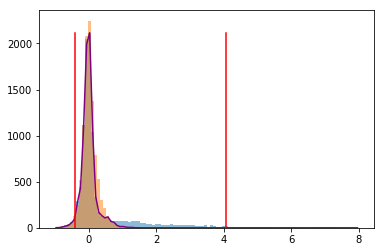

Got 314 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= 0.005528266668319702
Computing threshold
Thresholds from null dist were -0.9403437250293791  and  0.6126045659184456
Passing windows frac was 0.10949820788530466 , which is above  0.05 ; adjusting
Final raw thresholds are -0.4443425007164479  and  5.474776756763456
Final transformed thresholds are 0.9499695142605514  and  0.9499961945353528


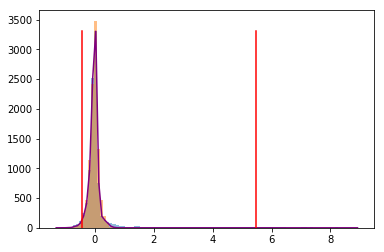

Got 363 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= 0.013941359907388687
Computing threshold
Thresholds from null dist were -0.6285901255905628  and  0.711358368396759
Passing windows frac was 0.1260931899641577 , which is above  0.05 ; adjusting
Final raw thresholds are -0.48100804686546317  and  7.541630959510803
Final transformed thresholds are 0.9499783142981061  and  0.9499857813166501


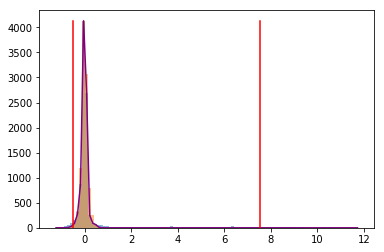

Got 344 coords
After resolving overlaps, got 655 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9499694142605515
655 identified in total
2 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [276, 258]
Idx to activities:  {0: '1,0,1', 1: '1,1,0'}
On metacluster 1
Metacluster size 258
Relevant tasks:  ('task0', 'task1')
Relevant signs:  (1, 1)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 258
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.11 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.0 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.01 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculation job


Using TensorFlow backend.


Job completed in: 2.49 s
(Round 1) Computed affinity matrix on nearest neighbors in 2.71 s
Filtered down to 235 of 258
(Round 1) Retained 235 rows out of 258 after filtering
(Round 1) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 235 samples in 0.000s...
[t-SNE] Computed neighbors for 235 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 235 / 235
[t-SNE] Mean sigma: 0.281042
(Round 1) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.0178480148315 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 2.62132287025 seconds
Wrote graph to binary file in 0.0308971405029 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.690762
Louvain completed 51 runs in 0.989294052124 seconds
Preproc + Louvain took 3.73146986961 s
Got 7 clusters after round 1
Counts:
{0: 61, 1: 60, 2: 50, 3: 35, 4: 10, 5: 10, 6: 9}
(Round 1) Aggregatin

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.4s finished


Job completed in: 0.64 s
(Round 2) Computed affinity matrix on nearest neighbors in 0.71 s
Not applying filtering for rounds above first round
(Round 2) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 115 samples in 0.000s...
[t-SNE] Computed neighbors for 115 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 115 / 115
[t-SNE] Mean sigma: 0.250024
(Round 2) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.00804996490479 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 2.07380199432 seconds
Wrote graph to binary file in 0.0102601051331 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.472128
After 14 runs, maximum modularity is Q = 0.50748
Louvain completed 64 runs in 1.17871999741 seconds
Preproc + Louvain took 3.31698298454 s
Got 4 clusters after round 2
Counts:
{0: 53, 1: 52, 2: 6, 3: 4}
(Round 2) Aggregating se

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished


Computing pattern to pattern distances
Got 4 patterns after merging
Performing seqlet reassignment
Got 0 patterns after reassignment
Total time taken is 12.75s
On metacluster 0
Metacluster size 276
Relevant tasks:  ('task0', 'task2')
Relevant signs:  (1, 1)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 276
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.05 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.0 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.01 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculation job
Job completed in: 2.45 s
(Round 1) Computed affinity matrix on nearest neighbors in 2.67 s
Filtered down to 233 of 276
(Round 1) Retained 233 rows out of 276 after filtering
(Round 1) C

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.0s finished


Job completed in: 0.84 s
(Round 2) Computed affinity matrix on nearest neighbors in 0.92 s
Not applying filtering for rounds above first round
(Round 2) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 146 samples in 0.000s...
[t-SNE] Computed neighbors for 146 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 146 / 146
[t-SNE] Mean sigma: 0.230526
(Round 2) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.0105538368225 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 2.17956185341 seconds
Wrote graph to binary file in 0.011305809021 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.705816
Louvain completed 51 runs in 0.86728811264 seconds
Preproc + Louvain took 3.10705089569 s
Got 5 clusters after round 2
Counts:
{0: 37, 1: 35, 2: 32, 3: 29, 4: 13}
(Round 2) Aggregating seqlets in each cluster
Aggregating for clus

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished


Computing pattern to pattern distances
Collapsing 2 & 3 with prob 0.00024529675732575955 and sim 1.9646078033842167
Collapsing 0 & 1 with prob 0.0015242932990563473 and sim 1.9593211017811019
Collapsing 3 & 4 with prob 1.6213145528242867e-05 and sim 1.922392498477541
Collapsing 2 & 4 with prob 5.710501017831141e-05 and sim 1.9004558661267814
Trimmed 0 out of 55
Trimmed 1 out of 69
Trimmed 0 out of 66
On merging iteration 2
Computing pattern to seqlet distances
Computing pattern to pattern distances
Got 2 patterns after merging
Performing seqlet reassignment
Skipped 2 seqlets
Skipped 2 seqlets
Got 2 patterns after reassignment
Total time taken is 12.87s


In [6]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    min_passing_windows_frac=0.05,
                    max_passing_windows_frac=0.05,
                    separate_pos_neg_thresholds=True,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data,
                revcomp=False)

## Save and print the results

In [7]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

In [8]:
import h5py
import numpy as np
from collections import OrderedDict
import modisco.util
import modisco.core
reload(modisco.core)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow
reload(workflow)
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data,
                revcomp=False)
grp = h5py.File("results.hdf5","r")
tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

metacluster idx metacluster_0
num seqlets 66
one hot
fwd


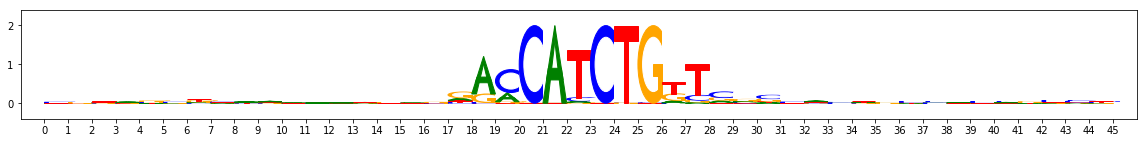

Task 0 hypothetical scores:
fwd


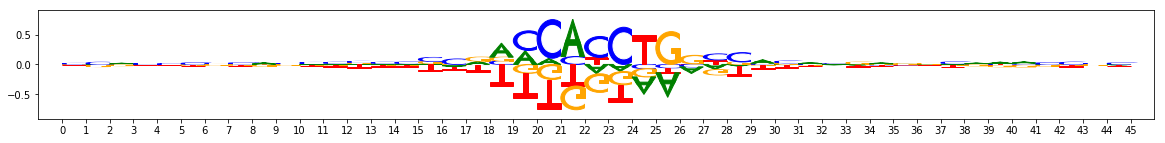

Task 0 actual importance scores:
fwd


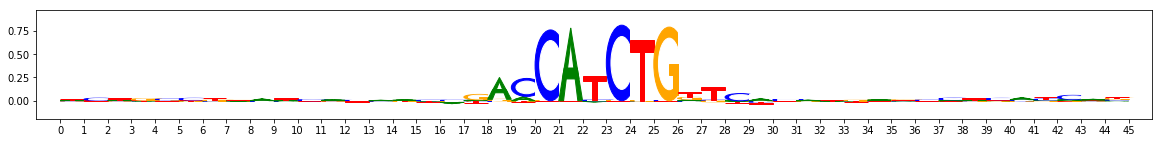

Task 1 hypothetical scores:
fwd


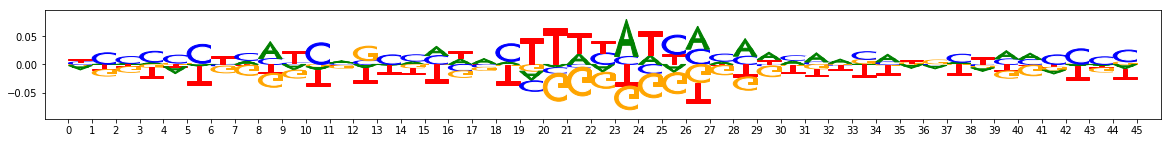

Task 1 actual importance scores:
fwd


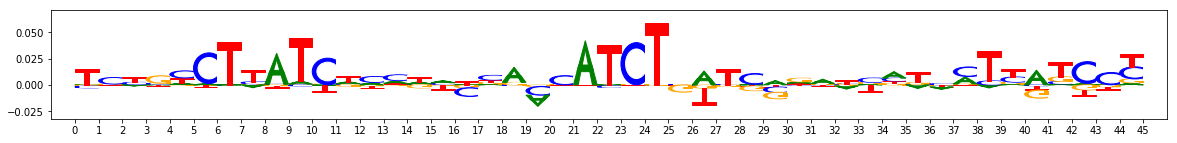

Task 2 hypothetical scores:
fwd


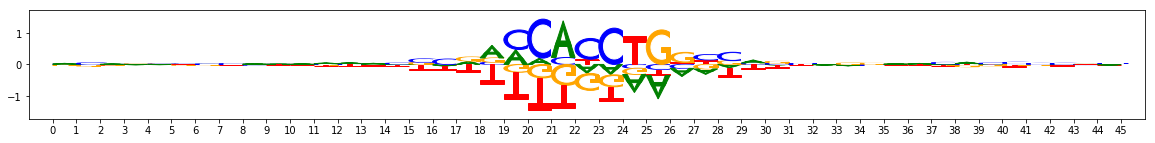

Task 2 actual importance scores:
fwd


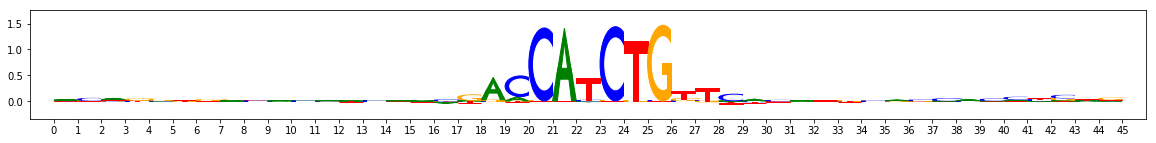

num seqlets 64
one hot
fwd


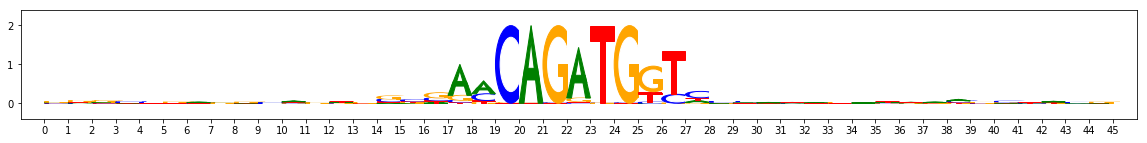

Task 0 hypothetical scores:
fwd


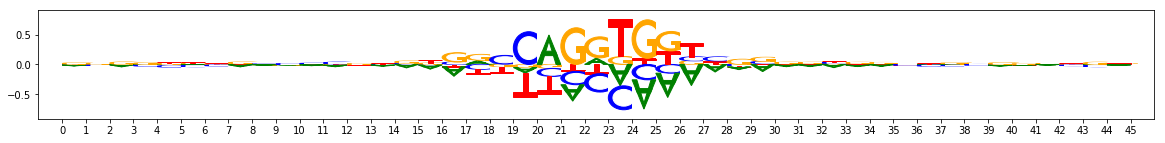

Task 0 actual importance scores:
fwd


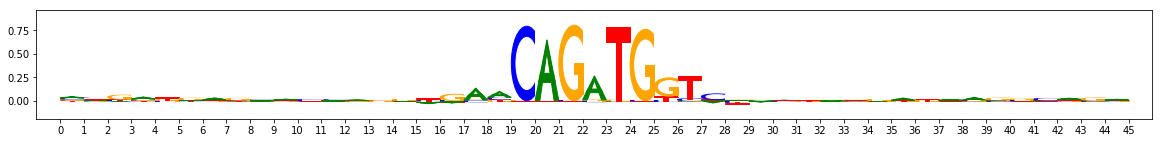

Task 1 hypothetical scores:
fwd


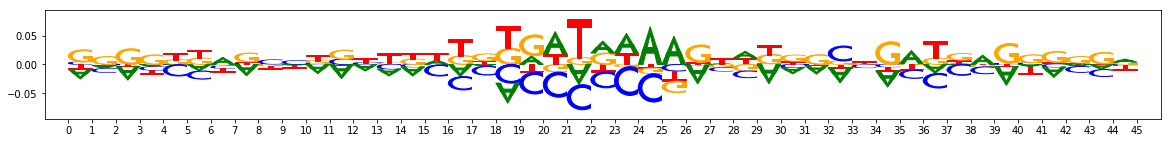

Task 1 actual importance scores:
fwd


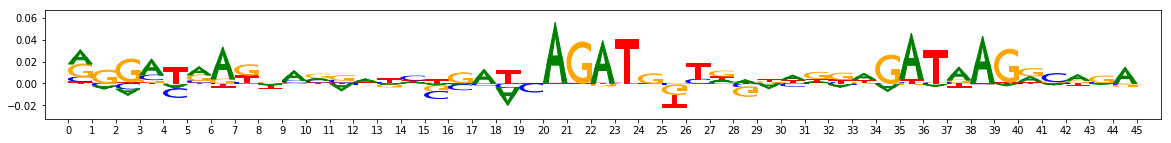

Task 2 hypothetical scores:
fwd


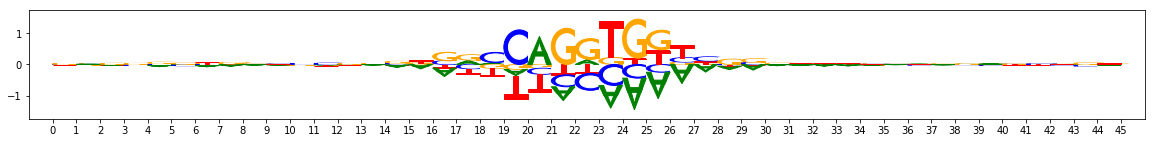

Task 2 actual importance scores:
fwd


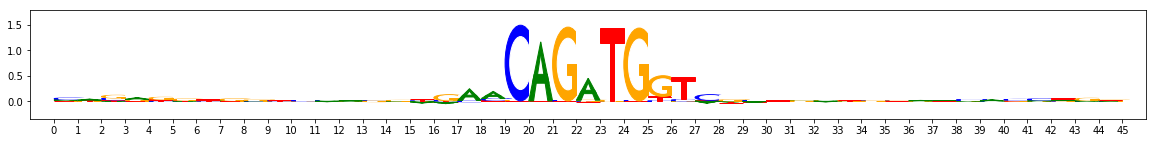

metacluster idx metacluster_1


In [9]:
from modisco.visualization import viz_sequence
reload(viz_sequence)

for metacluster_idx in tfmodisco_results.metacluster_idx_to_submetacluster_results:
    print("metacluster idx", metacluster_idx)
    patterns = (tfmodisco_results
          .metacluster_idx_to_submetacluster_results[metacluster_idx]
          .seqlets_to_patterns_result.patterns)
    for pattern in patterns:
        print("num seqlets", len(pattern.seqlets))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        
        print("one hot")
        print("fwd")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"].fwd),
                                                        background=background)) 
        if (pattern["sequence"].rev is not None):
            print("rev")
            viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"].rev),
                                                            background=background)) 
        
        print("Task 0 hypothetical scores:")
        print("fwd")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)
        if (pattern["sequence"].rev is not None):
            print("rev")
            viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev)
        print("Task 0 actual importance scores:")
        print("fwd")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
        if (pattern["sequence"].rev is not None):
            print("rev")
            viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev)
        
        print("Task 1 hypothetical scores:")
        print("fwd")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"].fwd)
        if (pattern["sequence"].rev is not None):
            print("rev")
            viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"].rev)
        print("Task 1 actual importance scores:")
        print("fwd")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"].fwd)
        if (pattern["sequence"].rev is not None):
            print("rev")
            viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"].rev)
        
        print("Task 2 hypothetical scores:")
        print("fwd")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"].fwd)
        if (pattern["sequence"].rev is not None):
            print("rev")
            viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"].rev)
        print("Task 2 actual importance scores:")
        print("fwd")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"].fwd)
        if (pattern["sequence"].rev is not None):
            print("rev")
            viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"].rev)
        